# The objectives comprised of two folds:
# <a href='#resting-state'>1. Resting State</a>

# <a href='#ISC'>2. Inter-subject Correlation study (ISC)</a>

In [1]:
import mne
import pathlib
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import numpy as np

In [2]:
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
import os
subjs = ['NDARCD401HGZ','NDARDX770PJK', 'NDAREZ098ZPE', 'NDARGY054ENV', 'NDARMR242UKQ', 'NDARRD720XZK', 'NDARTR840XP1', 'NDARXJ696AMX', 'NDARYY218AGA', 'NDARZP564MHU']


In [14]:
cd /usr/slurm/venkatesh/HBN/

/usr/slurm/venkatesh/HBN


In [33]:
def csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,filename,state,montage = 'GSN-HydroCel-129'):
    ''' Load csv files of data, chan locations and events and return a raw mne instance'''
    data = np.loadtxt(path_to_file,delimiter =',')
    chans = pd.read_csv(path_to_montage_ses,sep = ',',header = None)
    ch_list=['E1', 'E8', 'E14', 'E17', 'E21', 'E25', 'E32', 'E38', 'E43', 'E44', 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114', 'E119', 'E120', 'E121', 'E125', 'E126', 'E127', 'E128']
    print(len(ch_list))
    ch_names = list(chans.values[1:,0])

    
    if state == 'Rest':
        ch_names_appended = list(np.append(ch_names,'stim_channel'))
        types = ['eeg']*(len(ch_names_appended)-1)
        types.append('stim')
        data2 = np.zeros([1,len(data[0])]) #len(raw.times)
        data_appended = np.append(data,data2,axis = 0)
        info = mne.create_info(ch_names_appended,sfreq = fs,ch_types = types)
        raw = mne.io.RawArray(data_appended, info)
    
    else:   
        types = ['eeg']*(len(ch_names))
        info = mne.create_info(ch_names,sfreq = fs,ch_types = types)
        raw = mne.io.RawArray(data, info)
    
    # set standard montage
    if montage:
        raw.set_montage(montage)

    if path_to_events:
        # parse events file
        raw_events = pd.read_csv(path_to_events, sep = r'\s*,\s*', header = None, engine = 'python')
        values = raw_events[0].to_list()
        
        
        print(filename)
        if filename == 'NDARDX770PJK':
            values.extend(["break cnt"])
            
        idx = [i for i, e in enumerate(values) if e == 'break cnt']
        if state == 'Rest': 
            #idx = [i for i, e in enumerate(values) if e == 'break cnt']
            samples = raw_events[1][idx[0] + 1:idx[1]].to_numpy(dtype = int)
            event_values = raw_events[0][idx[0] + 1:idx[1]].to_numpy(dtype = int)
            
        else:
            samples = raw_events[1][1:idx[0]].to_numpy(dtype = int)
            event_values = raw_events[0][1:idx[0]].to_numpy(dtype = int)
     

        events = np.zeros((len(samples), 3))
        
        events = events.astype('int')
        events[:, 0] = samples
        events[:, 2] = event_values
        
        # Appending one row of 'ones'. Will be easier to stop parsing once we hit 1
        events_final = np.append(events,np.ones((1, 3)),axis = 0).astype('int')
        raw = exclude_channels_from_raw(raw, ch_list)
        
    return raw,events_final

def exclude_channels_from_raw(raw,ch_to_exclude):
    '''Return a raw structure where ch_to_exclude are removed'''
    idx_keep = mne.pick_channels(raw.ch_names,include = raw.ch_names,exclude = ch_to_exclude)
    raw.pick_channels([raw.ch_names[pick] for pick in idx_keep])
    print('yes')
    return raw



def preparation(filename,state):
    path_to_file = '%s/EEG/preprocessed/csv_format/Video3_data.csv'% filename
    path_to_events = '%s/EEG/preprocessed/csv_format/Video3_event.csv' %filename
    path_to_montage_glob = '/GSN_HydroCel_129_hbn.sfp'
    path_to_montage_ses = '%s/EEG/preprocessed/csv_format/Video3_chanlocs.csv' %filename
    fs = 500
    #chans_glob = mne.channels.read_custom_montage(fname = 'GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated

    raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,state=state,filename=filename,montage = 'GSN-HydroCel-129')
    #raw.add_events(events, stim_channel = 'stim_channel',replace = False)
    return raw,events

def preparation_resting_state(filename,state):
    path_to_file = '%s/EEG/preprocessed/csv_format/RestingState_data.csv'% filename
    path_to_events = '%s/EEG/preprocessed/csv_format/RestingState_event.csv' %filename
    path_to_montage_glob = 'GSN_HydroCel_129_hbn.sfp'
    path_to_montage_ses = '%s/EEG/preprocessed/csv_format/RestingState_chanlocs.csv' %filename
    fs = 500
   # chans_glob = mne.channels.read_custom_montage(fname = 'GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated


    raw, events = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,filename=filename,state=state,montage = 'GSN-HydroCel-129')
    #raw.add_events(events, stim_channel = 'stim_channel',replace = False)
    return raw,events


In [28]:
#cd
!pwd

/usr/slurm/venkatesh/HBN


# Resting State <a id='resting-state'></a>

In [29]:
rstate0_events

NameError: name 'rstate0_events' is not defined

In [34]:

for i in  [ v for v in np.arange(10) if v != 2]:
        globals()[f"rstate{i}"],globals()[f"rstate{i}_events"] = preparation_resting_state(subjs[i],'Rest')

#resting_state_sub1_events

37
Creating RawArray with float64 data, n_channels=112, n_times=185185
    Range : 0 ... 185184 =      0.000 ...   370.368 secs
Ready.
NDARCD401HGZ
yes
37
Creating RawArray with float64 data, n_channels=112, n_times=202806
    Range : 0 ... 202805 =      0.000 ...   405.610 secs
Ready.
NDARDX770PJK
yes


KeyboardInterrupt: 

### Raw structure

In [31]:
#resting_state_sub1_raw.info

### Plotting the Electrodes

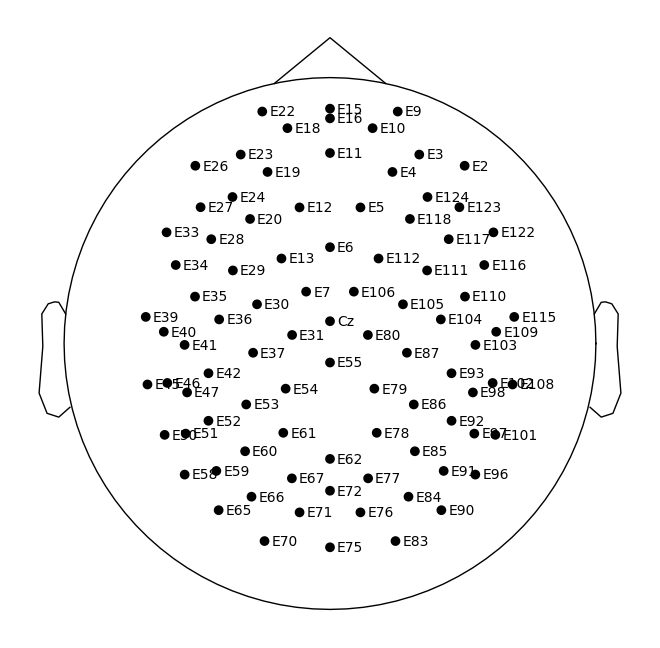

In [8]:

# kind = kinda standard which has 3D coordinates for 128 electrodes and 3 default things
#montage_plot = mne.channels.make_standard_montage(kind= "GSN-HydroCel-129")  
# Note: By default, the 3d plots displayed here does not show the 3rd axis, thus require a
# a package called qt, can be called with 
%matplotlib qt

resting_state_sub1_raw.plot_sensors(show_names=True)



### Raw data plot in Time domain

In [24]:
from Modular_Scripts import raw_time_domain
from imp import reload 

reload(raw_time_domain)
raw_time_domain.time_domain_plot(rstate0).show()


### Epoch (ing) the raw data

In [9]:
epochs = mne.Epochs(resting_state_sub1_raw, resting_state_sub1_events, [20,30,90], tmin=0, tmax=20,preload=True,baseline=(0,None))
epochs_resampled = epochs.resample(250) # Downsampling to 250Hz
np.shape(epochs_resampled.load_data()) # Sanity Check


NameError: name 'resting_state_sub1_raw' is not defined

### Topo Plot

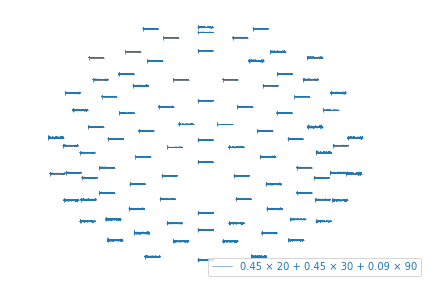

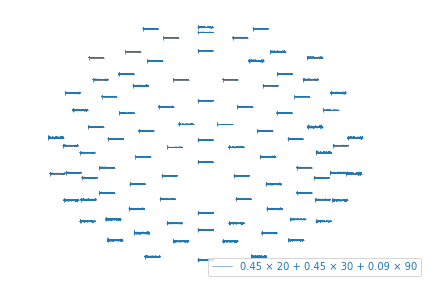

In [11]:
layout = mne.find_layout(epochs.info)
%matplotlib inline
epochs.average().plot_topo(layout=layout)



### Plotting events

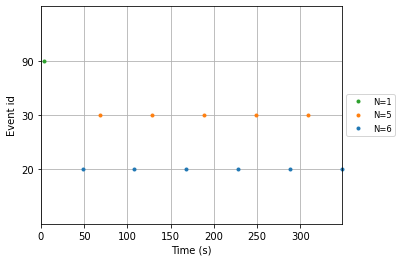

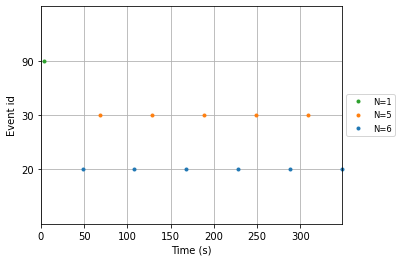

In [100]:
mne.viz.plot_events(resting_state_sub1_events[:-1], sfreq=resting_state_sub1_raw.info['sfreq'])
#The last event 20 falls on 174120 and the last sample is 176386. That's just 4 seconds before the end of the EEG

### Raw PSD 

Effective window size : 4.096 (s)


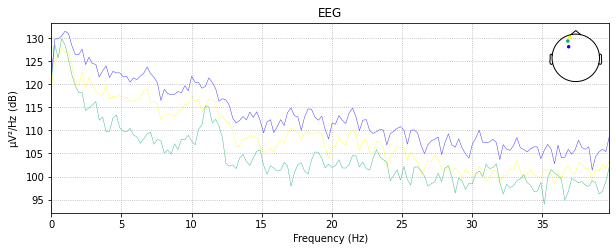

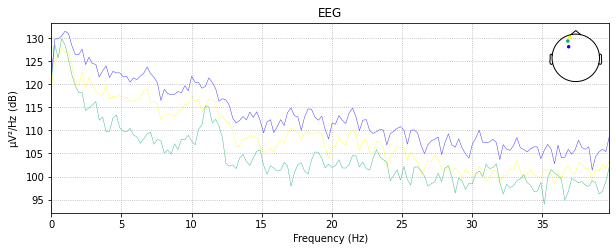

In [101]:
mne.viz.plot_raw_psd(resting_state_sub1_raw,tmax=40,fmax=40,picks=['E22','E20','E23'])

### Topomap PSD

    Using multitaper spectrum estimation with 7 DPSS windows


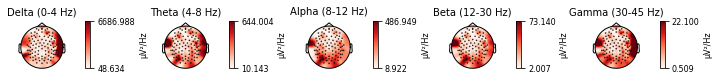

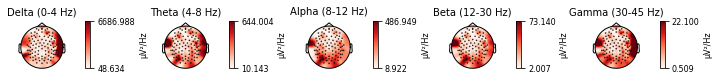

In [15]:
#epochs
mne.viz.plot_epochs_psd_topomap(epochs['20']) # Eyes open

### PSD plot for the electrodes located in Occipital lobe

			EVENT IN THE GRAPH BELOW IS = 90
			NOTE, EYES OPEN = 20 & EYES CLOSE = 30
			Onset at 4.036s
Effective window size : 4.096 (s)


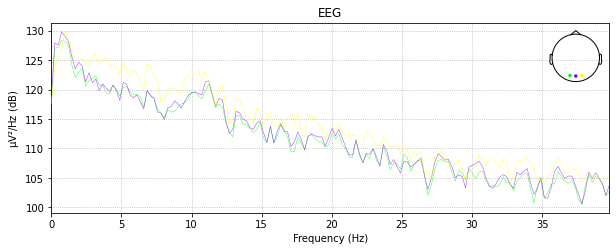

			EVENT IN THE GRAPH BELOW IS = 20
			NOTE, EYES OPEN = 20 & EYES CLOSE = 30
			Onset at 48.244s
Effective window size : 4.096 (s)


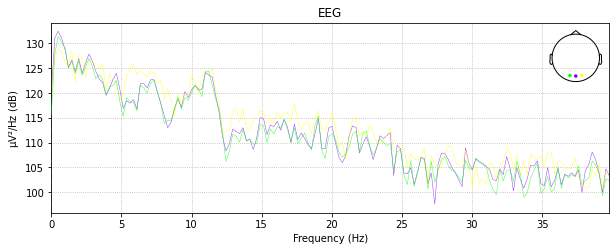

			EVENT IN THE GRAPH BELOW IS = 30
			NOTE, EYES OPEN = 20 & EYES CLOSE = 30
			Onset at 68.246s
Effective window size : 4.096 (s)


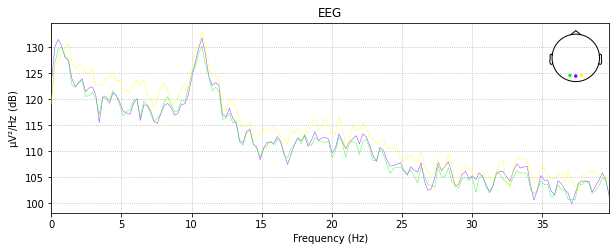

			EVENT IN THE GRAPH BELOW IS = 20
			NOTE, EYES OPEN = 20 & EYES CLOSE = 30
			Onset at 108.244s
Effective window size : 4.096 (s)


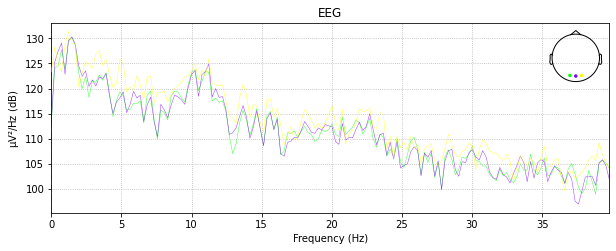

			EVENT IN THE GRAPH BELOW IS = 30
			NOTE, EYES OPEN = 20 & EYES CLOSE = 30
			Onset at 128.244s
Effective window size : 4.096 (s)


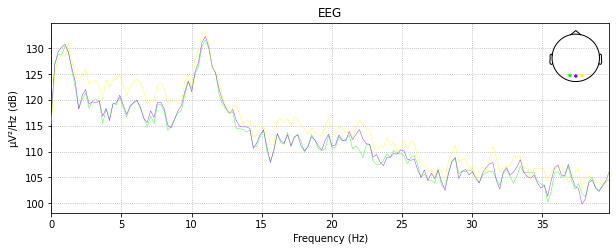

In [16]:
%matplotlib inline
for i in range(0,5): #0 is 90 = beginning of EEG, so skipped
    #plt.title('event ={}. Note: open = 20'.format(events[i][2])) this works nicely if plotted through qt
    print("\t\t\tEVENT IN THE GRAPH BELOW IS = {}".format(resting_state_sub1_events[i][2]))
    print("\t\t\tNOTE, EYES OPEN = 20 & EYES CLOSE = 30")
    print("\t\t\tOnset at {}s".format(resting_state_sub1_events[i][0]/500))
    mne.viz.plot_raw_psd(resting_state_sub1_raw,tmin= resting_state_sub1_events[i][0]/500,tmax=resting_state_sub1_events[i+1][0]/500,fmax=40,picks=['E70','E75','E83'])

    
# Types of waves: https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/brain-waves
    
#%matplotlib inline
#for i in range(1,5): #0 is 90 = beginning of EEG, so skipped
    #plt.title('event ={}. Note: open = 20'.format(events[i][2])) this works nicely if plotted through qt
    #print("\t\t\tEVENT IN THE GRAPH BELOW IS = {}".format(events[i][2]))
    #print("\t\t\tNOTE, EYES OPEN = 20 & EYES CLOSE = 30")
    #mne.viz.plot_raw_psd(raw,tmin= events[i][0]/500,tmax=events[i+1][0]/500,fmax=40,picks=['E34','E33'])


### Source Reconstruction

In [39]:

from data import source_inversion,fwd_model
reload(source_inversion)
#reload(fwd_model)

#epochs_ISC = mne.EpochsArray(np.reshape(isc_results['condition1']['A'][:],[1,91,91]),mne.create_info(sub1_raw.info['ch_names'],sfreq=1,ch_types = 'eeg'))
forward_model = fwd_model.fwd(resting_state_sub1_raw)

resting_state_cov, resting_state_inverse_operator = source_inversion.inversion(resting_state_sub1_raw,epochs_resampled,forward_model,0,['shrunk', 'empirical'])

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


<module 'data.source_inversion' from '/homes/v20subra/S4B2/data/source_inversion.py'>

In [19]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2

# epochs['30'].average() = Averaged evoked response for the event 30

'''Memory gets exhausted if entire 352s of data is used'''
#stc = apply_inverse_epochs(epochs_resampled['20'], resting_state_inverse_operator, lambda2,
 #                            method=method, pick_ori=None, verbose=True)

'Memory gets exhausted if entire 352s of data is used'

### Source PSD epochs for Occipital region

In [20]:
#stc2=stc[0].in_label(mne.Label(inverse_operator['src'][0]['vertno'], hemi='lh') +
    #              mne.Label(inverse_operator['src'][1]['vertno'], hemi='rh'))
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd_epochs

data_path = sample.data_path()
label_name ='Vis-rh.label' # Have to use 2 labels at the same, but will deal with this later
fname_label = data_path + '/MEG/sample/labels/%s' % label_name
label_name2 = 'Vis-lh.label'
fname_label2 = data_path + '/MEG/sample/labels/%s' % label_name2
label = mne.read_label(fname_label)
label2 = mne.read_label(fname_label2)
bihemi = mne.BiHemiLabel(label,label2)

stcs = compute_source_psd_epochs(epochs_resampled['20'], resting_state_inverse_operator, lambda2=lambda2,
                                 method=method, fmin=0, fmax=40, label=bihemi,
                                  verbose=True)

stcs2 = compute_source_psd_epochs(epochs_resampled['30'], resting_state_inverse_operator, lambda2=lambda2,
                                 method=method, fmin=0, fmax=40, label=bihemi,
                                  verbose=True)



Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 11 (80 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (7.2e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 11
Using 78 tapers with bandwidth 4.0 Hz on 5 epochs


  0%|          |  : 0/5 [00:00<?,       ?it/s]

Considering frequencies 0 ... 40 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 11 (80 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (7.2e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 11
Using 78 tapers with bandwidth 4.0 Hz on 5 epochs


  0%|          |  : 0/5 [00:00<?,       ?it/s]

### PSD at source

In [31]:
from data import compute_psd_at_source
reload(compute_psd_at_source)
compute_psd_at_source.compute(resting_state_sub1_raw,forward_model)


Using up to 1763 segments
Number of samples used : 176300
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.34 (2.2e-16 eps * 91 dim * 1.7e+13  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Com

/homes/v20subra/S4B2/data/compute_psd_at_source.py:21: RuntimeWarning:

No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.

/homes/v20subra/S4B2/data/compute_psd_at_source.py:21: RuntimeWarning:

No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.



    largest singular value = 5.1363
    scaling factor to adjust the trace = 2.44292e+16 (nchan = 91 nzero = 0)
Not setting metadata
Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Considering frequencies 0 ... 200 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (4.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Reducing data rank 91 -> 61
Using hann windowing on at 

  0%|          |  : 0/172 [00:00<?,       ?it/s]

({'vv': {},
  'opm': {},
  'delta': <Evoked | '' (average, N=1), 0 – 0 sec, baseline off, 91 ch, ~133 kB>,
  'theta': <Evoked | '' (average, N=1), 0 – 0 sec, baseline off, 91 ch, ~133 kB>,
  'alpha': <Evoked | '' (average, N=1), 0 – 0 sec, baseline off, 91 ch, ~133 kB>,
  'beta': <Evoked | '' (average, N=1), 0 – 0 sec, baseline off, 91 ch, ~133 kB>,
  'gamma': <Evoked | '' (average, N=1), 0 – 0 sec, baseline off, 91 ch, ~133 kB>},
 {'vv': {},
  'opm': {},
  'delta': <SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 3051.7578125 (ms), tmax : 3051.7578125 (ms), tstep : 2197.265625 (ms), data shape : (20484, 1), ~320 kB>,
  'theta': <SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 6103.515625 (ms), tmax : 6103.515625 (ms), tstep : 2441.40625 (ms), data shape : (20484, 1), ~320 kB>,
  'alpha': <SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 10620.1171875 (ms), tmax : 10620.1171875 (ms), tstep : 5126.953125 (ms), data shape : (20484, 1), ~320 kB>,
  'b

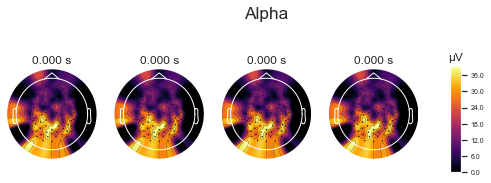

In [32]:
%matplotlib notebook

topos['alpha'].plot_topomap(scalings=1., cbar_fmt='%0.1f', title='Alpha', vmin=0, cmap='inferno',outlines='skirt')

### Source PSD for eyes closed

In [38]:
stcs_averaged_eyes_open = np.sum(stcs)/5
stcs_averaged_eyes_closed = np.sum(stcs2)/5

m = np.mean(stcs_averaged_eyes_closed.data.T,axis=1)
s = 2 * np.std(stcs_averaged_eyes_closed.data.T,axis=1)

top = m+s
bottom = m-s

from data import sns_plot
reload(sns_plot)


sns_plot.plot(x = stcs_averaged_eyes_closed.times, y = m,\
 xlabel = 'Frequency (Hz)',
 ylabel = 'V^2/hz (PSD)',
 title = 'Source PSD for eyes closed',
 color='b',\
 top = top, bottom = bottom,axis=[0,40,0e-9,2.8e-9],fill_between=True)

NameError: name 'stcs' is not defined

### Source PSD for eyes opened

In [47]:
m1 = np.mean(stcs_averaged_eyes_open.data.T,axis=1)
s = 2 * np.std(stcs_averaged_eyes_open.data.T,axis=1)

top = m1+s
bottom = m1-s

sns_plot.plot(x = stcs_averaged_eyes_open.times, y = m1,
 xlabel = 'Frequency (Hz)',
 ylabel = 'V^2/hz (PSD)',
 title = 'Source PSD for eyes opened',
 color='b',
 top = top, bottom = bottom,axis=[0,40,0e-9,2.8e-9],fill_between=True)

### Null Hypothesis T-test

In [55]:
from scipy import stats
import scipy
#a = []
a = stats.ttest_rel(np.average(stcs_averaged_eyes_closed.data[:,160:262],axis=1),np.average(stcs_averaged_eyes_open.data[:,160:262],axis=1))
#np.shape(stcs_averaged_eyes_open.data)
a
#8-13
#260*40/801 
#160
#261
#801/5


Ttest_relResult(statistic=19.876247511458242, pvalue=1.2157860440510008e-62)

# 2. Video-Watching state (Inter-subject Correlation Study)  <a id='ISC'></a>

In [35]:
sub1_raw,sub1_events = preparation(subjs[0],'others')
sub2_raw,sub2_events = preparation(subjs[1],'others')
sub3_raw,sub3_events = preparation(subjs[2],'others')
sub4_raw,sub4_events = preparation(subjs[3],'others')
sub5_raw,sub5_events = preparation(subjs[4],'others')
sub6_raw,sub6_events = preparation(subjs[5],'others')
sub7_raw,sub7_events = preparation(subjs[6],'others')
sub8_raw,sub8_events = preparation(subjs[7],'others')
sub9_raw,sub9_events = preparation(subjs[8],'others')
sub10_raw,sub10_events = preparation(subjs[9],'others')



37
Creating RawArray with float64 data, n_channels=111, n_times=86040
    Range : 0 ... 86039 =      0.000 ...   172.078 secs
Ready.
NDARCD401HGZ
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=87720
    Range : 0 ... 87719 =      0.000 ...   175.438 secs
Ready.
NDARDX770PJK
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86030
    Range : 0 ... 86029 =      0.000 ...   172.058 secs
Ready.
NDAREZ098ZPE
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86092
    Range : 0 ... 86091 =      0.000 ...   172.182 secs
Ready.
NDARGY054ENV
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86564
    Range : 0 ... 86563 =      0.000 ...   173.126 secs
Ready.
NDARMR242UKQ
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86045
    Range : 0 ... 86044 =      0.000 ...   172.088 secs
Ready.
NDARRD720XZK
yes
37
Creating RawArray with float64 data, n_channels=111, n_times=86058
    Range : 0 ... 86057 =     

In [17]:
sub1_raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: E2, E3, E4, E5, E6, E7, E9, E10, E11, E12, E13, E15, E16, E18, ...
 chs: 91 EEG
 custom_ref_applied: False
 dig: 114 items (3 Cardinal, 111 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 91
 projs: []
 sfreq: 500.0 Hz
>

In [36]:
cd

/homes/v20subra


In [37]:
cd S4B2

/homes/v20subra/S4B2


In [38]:
# Import
from Modular_Scripts import epochs_slicing 
from Modular_Scripts import CCA
from Modular_Scripts import plot_matplotlib
from Modular_Scripts import source_inversion, surface_plot, fwd_model
from imp import reload 


reload(epochs_slicing)
reload(CCA)
reload(source_inversion)
reload(surface_plot)
reload(fwd_model)

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


/homes/v20subra/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


<module 'Modular_Scripts.fwd_model' from '/homes/v20subra/S4B2/Modular_Scripts/fwd_model.py'>

In [12]:
dic = dict()

dic['condition1'] = np.append(sub1_raw.get_data()[:91,516:85516].reshape(1,91,85000),sub2_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)

#for i in range(2,10):
#    dic['condition1'] = np.append(dic['condition1'],sub[i].get_data()[:,:86030].reshape(1,92,86030) ,axis=0)

dic['condition1'] = np.append(dic['condition1'],sub3_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub4_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub5_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub6_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub7_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub8_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub9_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)
dic['condition1'] = np.append(dic['condition1'],sub10_raw.get_data()[:91,516:85516].reshape(1,91,85000) ,axis=0)    

In [13]:
[W,ISC] = CCA.train_cca(dic)
#np.shape( sub1_raw.get_data() )

isc_results = dict()
for cond_key, cond_values in dic.items():
    isc_results[str(cond_key)] = dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], CCA.apply_cca(cond_values, W, 500)))


train_cca - calculations started. There are 1 conditions
Condition has 10 subjects, 91 sensors and 85000 samples
Elapsed time: 3 seconds.
apply_cca - calculations started


In [16]:
isc_results

{'condition1': {'ISC': array([ 0.0735822 ,  0.06573835,  0.06459635,  0.06279999,  0.05765849,
          0.05259212,  0.05183896,  0.04994754,  0.04561473,  0.04421181,
          0.04335928,  0.04232103,  0.04209383,  0.04007945,  0.03563218,
          0.03313574,  0.03284281,  0.03207351,  0.03141303,  0.02855745,
          0.02542334,  0.02523704,  0.02502373,  0.02394124,  0.02280144,
          0.02030723,  0.01922108,  0.01682615,  0.01566496,  0.01506251,
          0.01458922,  0.01395903,  0.01282721,  0.00944428,  0.00886701,
          0.00845973,  0.00737035,  0.0056375 ,  0.00392349,  0.00222434,
          0.00125419,  0.00055904,  0.00029559, -0.00054023, -0.00211387,
         -0.00301819, -0.00426566, -0.00459674, -0.00650229, -0.00788167,
         -0.00888897, -0.01041865, -0.01138112, -0.01200293, -0.01209055,
         -0.01353281, -0.01615157, -0.01644308, -0.01765386, -0.01854844,
         -0.01877867, -0.01971902, -0.02103167, -0.0219131 , -0.02274689,
         -0.02384

Text(0.5, 1.0, 'ISC')

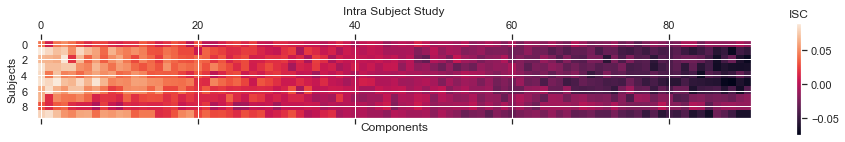

In [141]:
plt.matshow( (isc_results['condition1']['ISC_bysubject']).T)
plt.title('Intra Subject Study')
plt.ylabel('Subjects')
plt.xlabel('Components')

cb =plt.colorbar()
cb.ax.set_title('ISC')

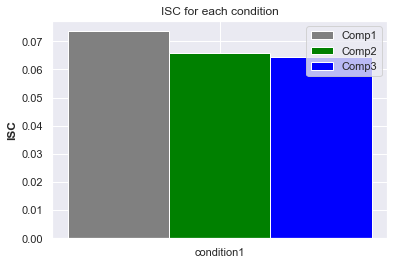

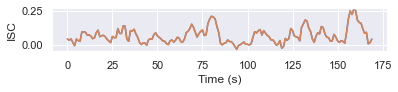

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def plot_isc(isc_all):
    # plot ISC as a bar chart
    plt.figure()
    comp1 = [cond['ISC'][0] for cond in isc_all.values()]
    comp2 = [cond['ISC'][1] for cond in isc_all.values()]
    comp3 = [cond['ISC'][2] for cond in isc_all.values()]
    barWidth = 0.2
    r1 = np.arange(len(comp1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    plt.bar(r1, comp1, color='gray', width=barWidth, edgecolor='white', label='Comp1')
    plt.bar(r2, comp2, color='green', width=barWidth, edgecolor='white', label='Comp2')
    plt.bar(r3, comp3, color='blue', width=barWidth, edgecolor='white', label='Comp3')
    plt.xticks([r + barWidth for r in range(len(comp1))], isc_all.keys())
    plt.ylabel('ISC', fontweight='bold')
    plt.title('ISC for each condition')
    plt.legend()
    plt.show()

    # plot ISC_persecond
    for cond in isc_all.values():
        for comp_i in range(1):
            plt.subplot(3, 1, comp_i+1)
            plt.plot(cond['ISC_persecond'][comp_i])
            #plt.plot ((np.array(vals)[:,comp_i,:]).T)
            #peaks = scipy.signal.find_peaks(isc_results['condition1']['ISC_persecond'][comp_i],distance=15)
            plt.subplots_adjust(hspace=1)

            plt.plot(isc_results['condition1']['ISC_persecond'][comp_i])
            #plt.plot(peaks[0],isc_results['condition1']['ISC_persecond'][comp_i][peaks[0]],marker='o', ls="")

            
            plt.xlabel('Time (s)')
            plt.ylabel('ISC')
            

            #plt.title('ISC per second for each condition')
    
plot_isc(isc_results)


In [26]:
np.savez_compressed('/users/local/Venkatesh/Generated_Data/CCA_ISC',CCA_ISC=isc_results['condition1']['ISC_persecond'])

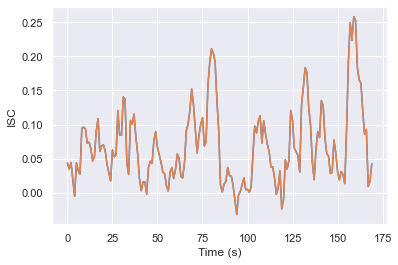

### Noise Floor

In [26]:
#a = list(range(100))
import random
from tqdm.notebook import tqdm

def shuffle(a):
    
    for i in (range(10)):
        for j in range(91):
            np.random.seed(i)
            
            chunked = chunks(a['condition1'][i][j][:85000])
            np.random.shuffle(chunked[0])
            chunked = np.reshape(chunked,[85000,])
            
    return a

def chunks(chunk):
    chunked = chunk[:85000]
    chunked= chunked.reshape(1,34,2500) #5s chunk
    return chunked

valstest = []
for i in tqdm(range(1000)):
    shuffled = shuffle(dic)
    isc_resultstest_ = dict()
    for cond_key, cond_values in shuffled.items():
        isc_resultstest_[str(cond_key)] = dict(zip(['ISC', 'ISC_persecond', 'ISC_bysubject', 'A'], CCA.apply_cca(cond_values, W, 500)))
        #print(np.mean(isc_results['condition1']['ISC_persecond'][0]))
        valstest.append(isc_resultstest_['condition1']['ISC_persecond'])
        #print(np.shape(isc_resultstest_['condition1']['ISC_persecond']))
#np.append(sub1_raw.get_data()[:91,516:85779].reshape(1,91,85263),sub2_raw.get_data()[:91,516:85779].reshape(1,91,85263) ,axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca - calculations started
apply_cca 

In [ ]:
#significance = np.where(np.max(np.array(valstest)[:,0,:],axis=0)<isc_results['condition1']['ISC_persecond'][0])
np.savez_compressed('/users/local/Venkatesh/Generated_Data/noise_floor', a=valstest)

#np.shape(np.load('noise_floor.npz')['a'])

FileNotFoundError: [Errno 2] No such file or directory: 'noise_floor.npz'

In [77]:
%matplotlib qt
reload(sns_plot)
sns_plot.plot(range(1,171),isc_results['condition1']['ISC_persecond'][0],xlabel = 'time (s)', ylabel = 'ISC',\
                                title = 'First component with 5-seconds block',\
                                color='r',fill_between=False)



In [126]:
reload(sns_plot) # 'Reload' updates immediately the pointer in memory of the edited script

significance = np.where(np.max(np.array(valstest)[:,0,:],axis=0)<isc_results['condition1']['ISC_persecond'][0])

sns_plot.plot(range(1,171),isc_results['condition1']['ISC_persecond'][0])
sns_plot.plot(range(1,171),np.max(np.array(valstest)[:,0,:],axis=0).T,color='grey')
sns_plot.plot(np.reshape(significance,(21,)),isc_results['condition1']['ISC_persecond'][0][significance],
              marker='o', ls="",color='red',
             title='First component with 5-seconds block',
             xlabel ='time (s)',
             ylabel='ISC')

### Source Inversion on ISC component

In [13]:
reload(source_inversion)
#reload(fwd_model)

epochs_ISC = mne.EpochsArray(np.reshape(isc_results['condition1']['A'][:],[1,91,91]),mne.create_info(sub1_raw.info['ch_names'],sfreq=1,ch_types = 'eeg'))
forward_model = fwd_model.fwd(sub1_raw)

cov, inverse_operator = source_inversion.inversion(sub1_raw,epochs_ISC,forward_model,tmax=None,method='empirical')

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Source space          : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /homes/v20subra/.local/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  

/homes/v20subra/S4B2/data/source_inversion.py:23: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  cov = mne.compute_covariance(epochs,tmax=tmax,method=method)
/homes/v20subra/S4B2/data/source_inversion.py:23: RuntimeWarning: Too few samples (required : 460 got : 91), covariance estimate may be unreliable
  cov = mne.compute_covariance(epochs,tmax=tmax,method=method)


    [done]
Computing inverse operator with 91 channels.
    91 out of 91 channels remain after picking
Selected 91 channels
Creating the depth weighting matrix...
    91 EEG channels
    limit = 20485/20484 = 2.194331
    scale = 146509 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 0.12 (2.2e-16 eps * 91 dim * 5.7e+12  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


/homes/v20subra/S4B2/data/source_inversion.py:25: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(raw.info, fwd_model, cov)
/homes/v20subra/S4B2/data/source_inversion.py:25: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  inverse_operator = make_inverse_operator(raw.info, fwd_model, cov)


    largest singular value = 9.53834
    scaling factor to adjust the trace = 8.79532e+16 (nchan = 91 nzero = 0)


In [250]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
from mne.minimum_norm import make_inverse_operator, apply_inverse, apply_inverse_epochs


epochs_ISC_2 = mne.EpochsArray(np.reshape(isc_results['condition1']['A'][0],[1,91,1]),mne.create_info(sub1_raw.info['ch_names'],sfreq=1,ch_types = 'eeg'))

# epochs['30'].average() = Averaged evoked response for the event 30
stc_isc = apply_inverse_epochs(epochs_ISC_2, inverse_operator, lambda2,
                             method=method, pick_ori=None, verbose=True)
stc_isc

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 91 (0 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 5 (1.3e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Picked 91 channels from the data
Computing inverse...
    Eigenleads already weighted ... 
Processing epoch : 1 / 1
combining the current components...
[done]


[<SourceEstimate | 20484 vertices, subject : fsaverage, tmin : 0.0 (ms), tmax : 0.0 (ms), tstep : 1000.0 (ms), data shape : (20484, 1), ~320 kB>]

(array([  5.,   9.,  15.,  27.,  26.,  90., 114., 187., 297., 408., 418.,
        378., 330., 291., 272., 266., 234., 247., 214., 245., 226., 182.,
        201., 174., 143., 183., 162., 164., 174., 171., 188., 174., 171.,
        172., 176., 162., 161., 175., 178., 189., 169., 171., 171., 183.,
        187., 162., 186., 183., 175., 173., 184., 182., 180., 193., 228.,
        201., 203., 213., 221., 207., 184., 207., 214., 210., 235., 237.,
        235., 223., 240., 249., 259., 267., 296., 304., 292., 307., 342.,
        319., 356., 349., 346., 393., 350., 349., 355., 324., 336., 333.,
        278., 212., 220., 140.,  73.,  29.,  19.,   8.,  15.,   5.,   2.,
          1.]),
 array([-1.00000000e+00, -9.80000000e-01, -9.60000000e-01, -9.40000000e-01,
        -9.20000000e-01, -9.00000000e-01, -8.80000000e-01, -8.60000000e-01,
        -8.40000000e-01, -8.20000000e-01, -8.00000000e-01, -7.80000000e-01,
        -7.60000000e-01, -7.40000000e-01, -7.20000000e-01, -7.00000000e-01,
        -6.800

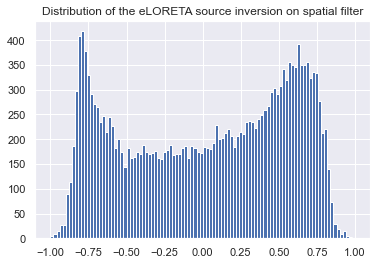

In [149]:
#averaged,to_test,b = difference_and_t_test('theta')
%matplotlib inline
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(stc_isc[0].data)
plt.title('Distribution of the eLORETA source inversion on spatial filter')
scaled = scaler.transform(stc_isc[0].data)
plt.hist(scaled,bins=100)

In [150]:
index = np.where( np.logical_or(scaled<-0.5, scaled>0.5))[0]
scaled[list(set(list(range(20484)))-set(index))] =0

In [155]:

reload(surface_plot)

%matplotlib qt
%gui qt

surface_plot.plot(mesh, mesh2, scaled, '1st spatial filter using eLORETA (after the threshold on range)')


In [10]:
#to find the peak
#np.where((isc_results['condition1']['ISC_persecond'][0]) == np.max(isc_results['condition1']['ISC_persecond'][0]))

# for the 7second -> 7*500
indexes = np.hstack([np.arange(160*500-50,160*500+50)])

### Source Inversion on Specific chunk of Raw EEG (100ms window around the peak of the peak)

In [39]:
def epochs(title,raw_bundle,events_bundle):
    for i in range(1, 11):
        globals()[f"epochs{i}_ISC"+title] = epochs_slicing.epochs(raw_bundle[i-1],events_bundle[i-1],[83,103,9999], tmin=0, tmax=170, fs = 500, epochs_to_slice='83')

In [40]:
reload(epochs_slicing)

raw_bundle = [sub1_raw,sub2_raw,sub3_raw,sub4_raw,sub5_raw,sub6_raw,sub7_raw,sub8_raw,sub9_raw,sub10_raw]
events_bundle = [sub1_events,sub2_events,sub3_events,sub4_events,sub5_events,sub6_events,sub7_events,sub8_events,sub9_events,sub10_events]

epochs("_g",raw_bundle,events_bundle)



Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 85001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 170.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 eve

Not setting metadata
Not setting metadata
12 matching events found
Setting baseline interval to [0.0, 1.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 501 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 2.8e-05 (2.2e-16 eps * 91 dim * 1.4e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed from 91 data channels with 0 projectors
Reducing data rank from 91 -> 91
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 501
log-likelihood on unseen data (descending order):
   empirical: -1281.162
   shrunk: -1340.841
   diagonal_fixed: -1447.904
selecting best estimator: empiri

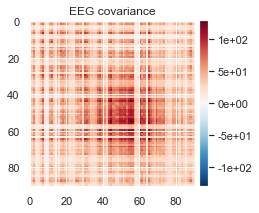

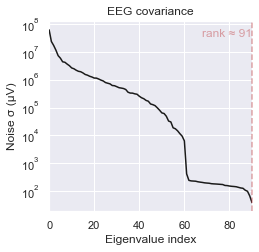

In [18]:
#1 4

epochs_for_noice_covariance = epochs_slicing.epochs(rstate1,rstate1_events,[20,30,90], tmin=0, tmax=1, fs = 500, epochs_to_slice='20')
noise_covariance = mne.compute_covariance(epochs_for_noice_covariance[4],  method='auto')

fig_cov, fig_spectra = mne.viz.plot_cov(noise_covariance, rstate1.info)

In [45]:
from Modular_Scripts import inverse_epochs,source_inversion,fwd_model
reload(inverse_epochs)
reload(source_inversion)
from mne.datasets import fetch_fsaverage


import os.path as op


fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)


subject = 'fsaverage' # Subject ID for the MRI-head transformation
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
source_space = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif') 
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')



forward_model = mne.make_forward_solution(sub1_raw.info, trans=trans, src=source_space, bem=bem, eeg=True, mindist=3.1)

def source_inversion_bundle(raw,inverse_operator):
    stc1 = inverse_epochs.apply(raw,inverse_operator)
    
    return stc1

def indexing_epochs(epochs,index,rstate,rstate_events,sub,downsample=False):
    indexed_epochs = epochs.get_data()[:,:,index]
    #print(np.shape(epochs))
    if downsample:
        
        info_d = mne.create_info(sub1_raw.info['ch_names'],sfreq=250,ch_types = 'eeg')
        ep = mne.EpochsArray(indexed_epochs,mne.create_info(sub1_raw.info['ch_names'],sfreq=500,ch_types = 'eeg'))
        ep = ep.resample(250)
        
        raw = mne.io.RawArray(ep.get_data().reshape(91,10625),info_d)
        raw.set_eeg_reference('average', projection=True)
    else:
        ep = mne.EpochsArray(indexed_epochs,mne.create_info(sub.info['ch_names'],sfreq=500,ch_types = 'eeg'))
        raw = mne.io.RawArray(ep.get_data().reshape(91,500),sub.info)
        raw.set_eeg_reference('average', projection=True)
        raw.apply_proj()

    epochs_for_noice_covariance = epochs_slicing.epochs(rstate,rstate_events,[83,103,9999], tmin=0, tmax=20, fs = 500, epochs_to_slice='9999')
    noise_covariance = mne.compute_covariance(epochs_for_noice_covariance[0],  method='auto')
    _,inverse_operator = source_inversion.inversion(raw,forward_model,noise_covariance)
    
    return source_inversion_bundle(raw,inverse_operator)



0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /homes/v20subra/.local/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head

In [42]:
#from data import apply_inverse_epochs
#reload(apply_inverse_epochs)
#stc1 = apply_inverse_epochs.apply(ep,inverse_operator)

stc1 =indexing_epochs(epochs1_ISC_ts,index=indexes,rstate=rstate0,rstate_events=rstate0_events)
stc2 =indexing_epochs(epochs2_ISC_ts,index=indexes,rstate=rstate1,rstate_events=rstate1_events)
stc3 =indexing_epochs(epochs3_ISC_ts,index=indexes,rstate=rstate1,rstate_events=rstate1_events)
stc4 =indexing_epochs(epochs4_ISC_ts,index=indexes,rstate=rstate3,rstate_events=rstate3_events)
stc5 =indexing_epochs(epochs5_ISC_ts,index=indexes,rstate=rstate4,rstate_events=rstate4_events)
stc6 =indexing_epochs(epochs6_ISC_ts,index=indexes,rstate=rstate5,rstate_events=rstate5_events)
stc7 =indexing_epochs(epochs7_ISC_ts,index=indexes,rstate=rstate6,rstate_events=rstate6_events)
stc8 =indexing_epochs(epochs8_ISC_ts,index=indexes,rstate=rstate7,rstate_events=rstate7_events)
stc9 =indexing_epochs(epochs9_ISC_ts,index=indexes,rstate=rstate8,rstate_events=rstate8_events)
stc10 =indexing_epochs(epochs10_ISC_ts,index=indexes,rstate=rstate9,rstate_events=rstate9_events)


NameError: name 'epochs1_ISC_ts' is not defined

In [ ]:
def average_source_inversion(*stcs):
    average = np.sum(stcs)/len(stcs)
    return average

In [ ]:
average_stc = average_source_inversion(stc1,stc2,stc3,stc4,stc5,stc6,stc7,stc8,stc9,stc10)

In [74]:
reload(surface_plot)
surface_plot.plot(average_stc.data,'trial','gnuplot')

### Specific chunk of filtered EEG(by first component and +/- 100ms around the peak)

In [55]:
170*500

85000

## Noise Covariance

In [48]:
events_bundle[0]



array([[    1,     0,  9999],
       [  507,     0,    83],
       [85779,     0,   103],
       [    1,     1,     1]])

### GSP - High and Low's spectra on Graph

In [44]:
indexes_high = np.hstack([np.arange(159*500-250,159*500+250)])#,np.arange(67*500,72*500),np.arange(77*500,84*500),np.arange(130*500,136*500),np.arange(155*500,165*500)])
indexes_low = np.hstack([np.arange(100*500-250,100*500+250)])
reload(inverse_epochs)
reload(source_inversion)

0 files missing from root.txt in /homes/v20subra/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /homes/v20subra/mne_data/MNE-fsaverage-data/fsaverage


<module 'Modular_Scripts.source_inversion' from '/homes/v20subra/S4B2/Modular_Scripts/source_inversion.py'>

In [49]:
events_bundle

[<RawArray | 91 x 86040 (172.1 s), ~59.9 MB, data loaded>,
 <RawArray | 91 x 87720 (175.4 s), ~61.0 MB, data loaded>,
 <RawArray | 91 x 86030 (172.1 s), ~59.9 MB, data loaded>,
 <RawArray | 91 x 86092 (172.2 s), ~59.9 MB, data loaded>,
 <RawArray | 91 x 86564 (173.1 s), ~60.2 MB, data loaded>,
 <RawArray | 91 x 86045 (172.1 s), ~59.9 MB, data loaded>,
 <RawArray | 91 x 86058 (172.1 s), ~59.9 MB, data loaded>,
 <RawArray | 91 x 86046 (172.1 s), ~59.9 MB, data loaded>,
 <RawArray | 91 x 101177 (202.4 s), ~70.4 MB, data loaded>,
 <RawArray | 91 x 86054 (172.1 s), ~59.9 MB, data loaded>]

In [50]:
src_high1 = indexing_epochs(epochs1_ISC_g,indexes_high,downsample=False,sub=sub1_raw,rstate=raw_bundle[0],rstate_events=events_bundle[0])
src_high2 = indexing_epochs(epochs2_ISC_g,indexes_high,downsample=False,sub=sub2_raw,rstate=raw_bundle[1],rstate_events=events_bundle[1])
src_high3 = indexing_epochs(epochs3_ISC_g,indexes_high,downsample=False,sub=sub3_raw,rstate=raw_bundle[2],rstate_events=events_bundle[2])
src_high4 = indexing_epochs(epochs4_ISC_g,indexes_high,downsample=False,sub=sub4_raw,rstate=raw_bundle[3],rstate_events=events_bundle[3])
src_high5 = indexing_epochs(epochs5_ISC_g,indexes_high,downsample=False,sub=sub5_raw,rstate=raw_bundle[4],rstate_events=events_bundle[4])
src_high6 = indexing_epochs(epochs6_ISC_g,indexes_high,downsample=False,sub=sub6_raw,rstate=raw_bundle[5],rstate_events=events_bundle[5])
src_high7 = indexing_epochs(epochs7_ISC_g,indexes_high,downsample=False,sub=sub7_raw,rstate=raw_bundle[6],rstate_events=events_bundle[6])
src_high8 = indexing_epochs(epochs8_ISC_g,indexes_high,downsample=False,sub=sub8_raw,rstate=raw_bundle[7],rstate_events=events_bundle[7])
src_high9 = indexing_epochs(epochs9_ISC_g,indexes_high,downsample=False,sub=sub9_raw,rstate=raw_bundle[8],rstate_events=events_bundle[8])
src_high10 = indexing_epochs(epochs10_ISC_g,indexes_high,downsample=False,sub=sub10_raw,rstate=raw_bundle[9],rstate_events=events_bundle[9])



Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 10001 original time points ...
1 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 91 dim * 3.4e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed fro

In [40]:
#src_high1[0].data #= indexing_epochs(epochs1_ISC_g,indexes_high,False)
high_isc_wo_average = [np.array(src_high1.data), np.array(src_high2.data), 
       np.array(src_high3.data),  np.array(src_high4.data),  
       np.array(src_high5.data), np.array(src_high6.data), 
       np.array(src_high7.data), np.array(src_high8.data), 
       np.array(src_high9.data), np.array(src_high10.data)]
np.savez_compressed('/users/local/Venkatesh/Generated_Data/indiv_cov/high_isc_wo_average_proper_cov.npz',high_isc_wo_average = high_isc_wo_average)

In [51]:
src_low1 = indexing_epochs(epochs1_ISC_g,indexes_low,downsample=False,sub=sub1_raw,rstate=raw_bundle[0],rstate_events=events_bundle[0])
src_low2 = indexing_epochs(epochs2_ISC_g,indexes_low,downsample=False,sub=sub2_raw,rstate=raw_bundle[1],rstate_events=events_bundle[1])
src_low3 = indexing_epochs(epochs3_ISC_g,indexes_low,downsample=False,sub=sub3_raw,rstate=raw_bundle[2],rstate_events=events_bundle[2])
src_low4 = indexing_epochs(epochs4_ISC_g,indexes_low,downsample=False,sub=sub4_raw,rstate=raw_bundle[3],rstate_events=events_bundle[3])
src_low5 = indexing_epochs(epochs5_ISC_g,indexes_low,downsample=False,sub=sub5_raw,rstate=raw_bundle[4],rstate_events=events_bundle[4])
src_low6 = indexing_epochs(epochs6_ISC_g,indexes_low,downsample=False,sub=sub6_raw,rstate=raw_bundle[5],rstate_events=events_bundle[5])
src_low7 = indexing_epochs(epochs7_ISC_g,indexes_low,downsample=False,sub=sub7_raw,rstate=raw_bundle[6],rstate_events=events_bundle[6])
src_low8 = indexing_epochs(epochs8_ISC_g,indexes_low,downsample=False,sub=sub8_raw,rstate=raw_bundle[7],rstate_events=events_bundle[7])
src_low9 = indexing_epochs(epochs9_ISC_g,indexes_low,downsample=False,sub=sub9_raw,rstate=raw_bundle[8],rstate_events=events_bundle[8])
src_low10 = indexing_epochs(epochs10_ISC_g,indexes_low,downsample=False,sub=sub10_raw,rstate=raw_bundle[9],rstate_events=events_bundle[9])



Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=91, n_times=500
    Range : 0 ... 499 =      0.000 ...     0.998 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Not setting metadata
Not setting metadata
3 matching events found
Setting baseline interval to [0.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 10001 original time points ...
1 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 91 dim * 3.4e+09  max singular value)
    Estimated rank (eeg): 91
    EEG: rank 91 computed fro

In [42]:
#src_high1[0].data #= indexing_epochs(epochs1_ISC_g,indexes_high,False)
low_isc_wo_average = [np.array(src_low1.data), np.array(src_low2.data), 
       np.array(src_low3.data),  np.array(src_low4.data),  
       np.array(src_low5.data), np.array(src_low6.data), 
       np.array(src_low7.data), np.array(src_low8.data), 
       np.array(src_low9.data), np.array(src_low10.data)]
np.savez('/users/local/Venkatesh/Generated_Data/indiv_cov/low_isc_wo_average_proper_cov.npz',low_isc_wo_average = low_isc_wo_average)

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters
from pygsp import plotting as gsp_plt
from nilearn import image, plotting, datasets


In [53]:
cd

/homes/v20subra


In [54]:
from pathlib import Path
from scipy import io as sio
from pygsp import graphs

path_Glasser='S4B2/GSP/Glasser_masker.nii.gz'
res_path=''

# Load structural connectivity matrix
connectivity = sio.loadmat('S4B2/GSP/SC_avg56.mat')['SC_avg56']
connectivity.shape
coordinates = sio.loadmat('S4B2/GSP/Glasser360_2mm_codebook.mat')['codeBook'] # coordinates in brain space


#G_Comb = graphs.Graph(connectivity,gtype='HCP subject',lap_type='combinatorial',coords=coordinates)# combinatorial laplacian
G=graphs.Graph(connectivity,gtype='HCP subject',lap_type='normalized',coords=coordinates) #
#G_RandW=graphs.Graph(connectivity,gtype='HCP subject',lap_type='normalized',coords=coordinates) #
print(G.is_connected())


G.set_coordinates('spring')
#G.plot()   #edges > 10^4 not shown
D=np.array(G.dw)
D.shape


True


(360,)

In [55]:
G.compute_fourier_basis()

In [56]:
import numpy as np
with np.load(f"/homes/v20subra/S4B2/GSP/hcp/atlas.npz") as dobj:
    atlas = dict(**dobj)

In [57]:
def averaging_by_parcellation(sub):
    l =list()
    for i in list(set(atlas['labels_L']))[:-1]:
        l.append(np.mean(sub.data[10242:][np.where(i== atlas['labels_L'])],axis=0))

    for i in list(set(atlas['labels_R']))[:-1]:
        l.append(np.mean(sub.data[:10242][np.where(i== atlas['labels_R'])],axis=0))
    return l

### Recomputation of ISC to probe eLORETA

In [58]:
high = [np.array(averaging_by_parcellation(src_high1)),np.array(averaging_by_parcellation(src_high2)), 
       np.array(averaging_by_parcellation(src_high3)), np.array(averaging_by_parcellation(src_high4)), 
       np.array(averaging_by_parcellation(src_high5)), np.array(averaging_by_parcellation(src_high6)),
       np.array(averaging_by_parcellation(src_high7)), np.array(averaging_by_parcellation(src_high8)), 
       np.array(averaging_by_parcellation(src_high9)), np.array(averaging_by_parcellation(src_high10))]


low = [np.array(averaging_by_parcellation(src_low1)),np.array(averaging_by_parcellation(src_low2)), 
       np.array(averaging_by_parcellation(src_low3)), np.array(averaging_by_parcellation(src_low4)), 
       np.array(averaging_by_parcellation(src_low5)), np.array(averaging_by_parcellation(src_low6)),
       np.array(averaging_by_parcellation(src_low7)), np.array(averaging_by_parcellation(src_low8)), 
       np.array(averaging_by_parcellation(src_low9)), np.array(averaging_by_parcellation(src_low10))]





In [59]:
np.savez('/users/local/Venkatesh/Generated_Data/indiv_cov/apply_projs/high_isc_averaged_with_cov',high_isc_averaged = high)
np.savez('/users/local/Venkatesh/Generated_Data/indiv_cov/apply_projs/low_isc_averaged_with_cov',low_isc_averaged = low)

In [3]:
import numpy as np

high_isc = np.load('high_isc_averaged.npz')
plot = list()
for m in range(360):
    hm = np.triu(np.corrcoef(np.array(high_isc['high_isc'])[:,m,:]))

    iscs = list()
    for i in range(9):
        iscs.append(np.sum(hm[i][i+1:]))
    plot.append(sum(iscs)/ sum(np.arange(10)))

In [49]:
#np.savez('low_isc_averaged',low_isc = low_isc)
%matplotlib qt
%gui qt
from nilearn.regions import signals_to_img_labels  
# load nilearn label masker for inverse transform
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
from nilearn import datasets
from os.path import join as opj


path_Glasser = 'S4B2/GSP/Glasser_masker.nii.gz'


mnitemp = fetch_icbm152_2009()
mask_mni=image.load_img(mnitemp['mask'])
glasser_atlas=image.load_img(path_Glasser)


#print(NiftiMasker.__doc__)

plt.show()
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10))

signal=[]
U0_brain=[]
signal=np.expand_dims(np.array(plot), axis=0) # add dimension 1 to signal array
U0_brain = signals_to_img_labels(signal,path_Glasser,mnitemp['mask'])
plotting.plot_glass_brain(U0_brain,title='Low ISC',colorbar=True,plot_abs=False,cmap='spring',display_mode='xz',figure=fig,axes=ax)



ImportError: Cannot load backend 'Qt5Agg' which requires the 'qt5' interactive framework, as 'headless' is currently running

In [174]:
low = [G.gft(np.array(averaging_by_parcellation(src_low1))),G.gft(np.array(averaging_by_parcellation(src_low2))), 
       G.gft(np.array(averaging_by_parcellation(src_low3))), G.gft(np.array(averaging_by_parcellation(src_low4))), 
       G.gft(np.array(averaging_by_parcellation(src_low5))), G.gft(np.array(averaging_by_parcellation(src_low6))),
       G.gft(np.array(averaging_by_parcellation(src_low7))), G.gft(np.array(averaging_by_parcellation(src_low8))), 
       G.gft(np.array(averaging_by_parcellation(src_low9))), G.gft(np.array(averaging_by_parcellation(src_low10)))]



In [27]:
high = [G.gft(np.array(averaging_by_parcellation(src_high1))),G.gft(np.array(averaging_by_parcellation(src_high2))), 
       G.gft(np.array(averaging_by_parcellation(src_high3))), G.gft(np.array(averaging_by_parcellation(src_high4))), 
       G.gft(np.array(averaging_by_parcellation(src_high5))), G.gft(np.array(averaging_by_parcellation(src_high6))),
       G.gft(np.array(averaging_by_parcellation(src_high7))), G.gft(np.array(averaging_by_parcellation(src_high8))), 
       G.gft(np.array(averaging_by_parcellation(src_high9))), G.gft(np.array(averaging_by_parcellation(src_high10)))]





### Subject-wise Spectra, while Time being variability

In [168]:
def mean_std(freq,ax):
    if ax>2:
        d = np.average(np.array(np.abs(freq)),axis=2)[:,1:]
    else: d = np.abs(freq[1:,:])
    mean_t = np.mean(d,axis=0)
    std_t = 2 * np.std(d,axis=0)
    top = mean_t + std_t
    bottom = mean_t - std_t
    
    return mean_t,std_t,top,bottom

### Power distribution finding

In [169]:
values,_,_,_ = mean_std(np.array(high),3)
np.sum(values)/2

0.0058668653507631865

In [53]:
np.sum(values[:78])

0.0026951572090805525

In [31]:
G.e[79]

0.8167845045595122

### Dichotomy 

In [32]:
#1
l = np.where(G.e<=0.82)[0][1:]
h = np.where(G.e>0.82)[0]

In [33]:
def filters(isc,band,length):
    indicator = np.ones([1,length])
    cll =list() 
    cll.append(np.matmul(indicator,np.abs(np.array(isc)[0,band,:]))) # 1 x length & length x time
    for i in range(1,10):
        cll.append(np.matmul(indicator,np.abs(np.array(isc)[i,band,:])))
    cll = np.reshape(cll,[10,500])
    return cll

In [34]:
#plt.plot(np.average(cll,axis=0).T)
np.shape(np.abs(np.array(low)[0,h,:]))

(280, 500)

In [35]:
np.savez_compressed('data.npz',mean_t1=mean_t1, mean_t2=mean_t2,mean_std=mean_std )

NameError: name 'mean_t1' is not defined

In [36]:
%matplotlib qt
%gui qt


#def lowISC_high_ISC(*typ):
a = 1  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
plt.figure(figsize=(15,15))
typ = {'High ISC':high,'Low ISC':low}
for i in range(2):
        
        plt.subplot(a, b, c)
        cll1 = filters(typ[list(typ.keys())[i]],l,len(l))
        cll2 = filters(typ[list(typ.keys())[i]],h,len(h))
        mean_t1,std_t1, top1, bottom1= mean_std(cll1,2)
        mean_t2,std_t2, top2, bottom2= mean_std(cll2,2)

        
        plt.legend()
        plt.plot(range(500),mean_t1,color='b')
        plt.fill_between(range(500),bottom1,top1, color='b', alpha=.1,label='Low')
        plt.plot(range(500),mean_t2,color='r')
        plt.fill_between(range(500),bottom2, top2, color='r', alpha=.1,label='High')
        plt.ylabel('gPSDs sliced using Eigen values')
        plt.xlabel('Time (s)',fontsize=10)
        plt.title(list(typ.keys())[i])
        plt.xticks(ticks=[0,125,250,375,500],labels=["-0.5","-0.25","0","0.25","0.5"],rotation='horizontal')
        plt.axvline(x=250, linestyle = '--', color='g')
        
        #plt.ylabel('log (gPSD)')
        c = c + 1
plt.suptitle('Dichotomized the eigen values(at 0.8) such that the power distribution is same & sliced the PSD using the same [Low freq = blue]')
plt.show()

# ideas:
#1. Sub-wise plot
#2. Freq-wise plot
#3. High - Low "dicotomized plot" and compare high - low heatmap



No handles with labels found to put in legend.
No handles with labels found to put in legend.


### Frequency-wise


In [44]:
%matplotlib qt
%gui qt


#def lowISC_high_ISC(*typ):
a = 1  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
plt.figure(figsize=(15,15))
typ = {'High ISC':high,'Low ISC':low}
freq = [l,h]
title = ['Low Frequency','High Frequency']
for i in range(2):
        
        plt.subplot(a, b, c)
        cll1 = filters(typ[list(typ.keys())[0]],freq[i],len(freq[i]))
        cll2 = filters(typ[list(typ.keys())[1]],freq[i],len(freq[i]))
        mean_t1,std_t1, top1, bottom1= mean_std(cll1,2)
        mean_t2,std_t2, top2, bottom2= mean_std(cll2,2)

        plt.legend()
        plt.plot(range(500),mean_t1,color='b')
        plt.fill_between(range(500),bottom1,top1, color='b', alpha=.1,label='High ISC')
        plt.plot(range(500),mean_t2,color='r')
        plt.fill_between(range(500),bottom2, top2, color='r', alpha=.1,label='Low ISC')
        #plt.title('Graph PSD for the conditions (CI = Subjects. Time = 0.6 - 0.7s, 50 samples)')
        plt.ylabel('gPSDs sliced using Eigen values')
        plt.xlabel('Time (s)',fontsize=10)
        plt.title(title[i])
        plt.xticks(ticks=[0,125,250,375,500],labels=["-0.5","-0.25","0","0.25","0.5"],rotation='horizontal')
        plt.axvline(x=250, linestyle = '--', color='g')
    
        c = c + 1
plt.suptitle('Dichotomized the eigen values(at 0.8) such that the power distribution is same & sliced the PSD using the same [blue = High ISC]')
plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


### Subject-wise

In [118]:
%matplotlib qt
%gui qt


def filters_subj(isc,band,length):
    indicator = np.ones([1,length])
    cll =list() 
    cll.append(np.matmul(indicator,np.abs(np.array(isc)[band,:])))
    
    cll = np.reshape(cll,[1,500])
    d = np.abs(freq[1:,:])
    #mean_t = np.mean(d,axis=0)
    #std_t = 2 * np.std(d,axis=0)
    #top = mean_t + std_t
    #bottom = mean_t - std_t
    
    return cll

#def lowISC_high_ISC(*typ):
a = 2  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter
plt.figure(figsize=(10,10))
typ = {'High ISC':high,'Low ISC':low}
freq = [l,h]
for i in range(10):
        plt.subplot(a, b, c)
        cll1 = filters_subj(typ[list(typ.keys())[0]][i],freq[0],len(freq[0]))
        cll2 = filters_subj(typ[list(typ.keys())[0]][i],freq[1],len(freq[1]))
        
        mean_t1,std_t1, top1, bottom1= mean_std(cll1,2)
        mean_t2,std_t2, top2, bottom2= mean_std(cll2,2)
        
        
        plt.legend()
        plt.plot(range(500),mean_t1,color='b')
        plt.fill_between(range(500),bottom1,top1, color='b', alpha=.1,label='Low')
        plt.plot(range(500),mean_t2,color='r')
        plt.fill_between(range(500),bottom2, top2, color='r', alpha=.1,label='High')
        #plt.title('Graph PSD for the conditions (CI = Subjects. Time = 0.6 - 0.7s, 50 samples)')
        plt.xticks(ticks=[0,125,250,375,500],labels=["-0.5","-0.25","0","0.25","0.5"],rotation='horizontal')
        plt.axvline(x=250, linestyle = '--', color='g')
        

        plt.ylabel('gPSDs sliced using Eigen values')
        plt.xlabel('Time (s)',fontsize=10)
        plt.title('Low freq (high ISC = blue)')
        #plt.ylabel('log (gPSD)')
        c = c + 1
plt.suptitle('Dichotomized the eigen values(at 0.8) such that the power distribution is same & sliced the PSD using the same [Low freq = blue]')
plt.show()

/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:206: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
No handles with labels found to put in legend.
/opt/campux/virtualenv/d

(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 500)


/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/campux/virtualenv/deeplearning-u20/lib/python3.8/site-packages/numpy/core/_methods.py:206: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
No handles with labels found to put in legend.


(1, 500)
(1, 500)


In [52]:
np.savez_compressed('data.npz',mean_t1=mean_t1, mean_t2=mean_t2,mean_std=mean_std )


high_isc = [(np.array(averaging_by_parcellation(src_high1))),(np.array(averaging_by_parcellation(src_high2))), 
       (np.array(averaging_by_parcellation(src_high3))), (np.array(averaging_by_parcellation(src_high4))), 
       (np.array(averaging_by_parcellation(src_high5))), (np.array(averaging_by_parcellation(src_high6))),
       (np.array(averaging_by_parcellation(src_high7))), (np.array(averaging_by_parcellation(src_high8))), 
       (np.array(averaging_by_parcellation(src_high9))), (np.array(averaging_by_parcellation(src_high10)))]

low_isc = [(np.array(averaging_by_parcellation(src_low1))),(np.array(averaging_by_parcellation(src_low2))), 
       (np.array(averaging_by_parcellation(src_low3))), (np.array(averaging_by_parcellation(src_low4))), 
       (np.array(averaging_by_parcellation(src_low5))), (np.array(averaging_by_parcellation(src_low6))),
       (np.array(averaging_by_parcellation(src_low7))), (np.array(averaging_by_parcellation(src_low8))), 
       (np.array(averaging_by_parcellation(src_low9))), (np.array(averaging_by_parcellation(src_low10)))]


diff = np.array(high_isc) - np.array(low_isc)




In [5]:
cd ..

/homes/v20subra/S4B2


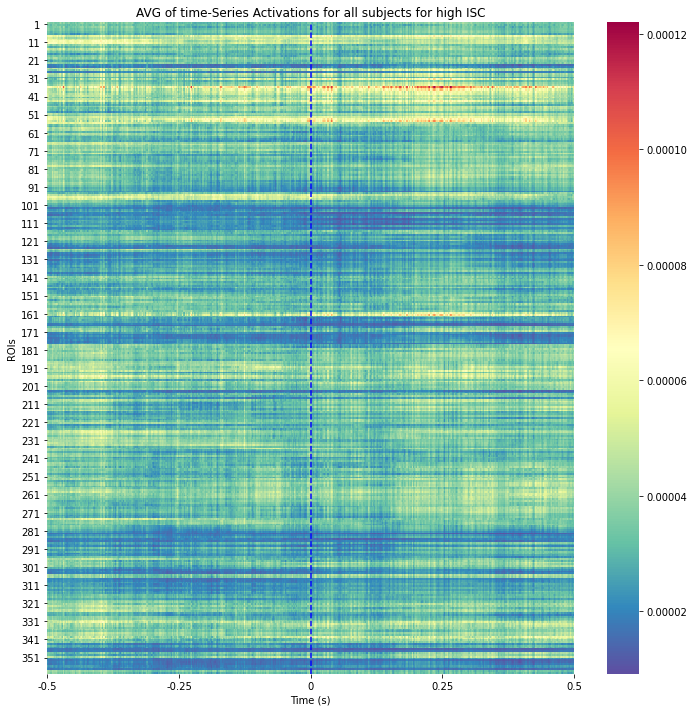

In [6]:
high = np.load('Generated_Data/high_isc_averaged_with_cov.npz')['high_isc_averaged']
low = np.load('Generated_Data/low_isc_averaged_with_cov.npz')['low_isc_averaged']

import seaborn as sns

import matplotlib
def activation_time_series(diff,title,start1,end1,div,start2,end2,operation):
    plt.figure(figsize=(10,10))
    cmap_reversed = matplotlib.cm.get_cmap('Spectral').reversed()
    if operation == 'std':
        sns.heatmap(np.std(diff,axis=0),cmap=cmap_reversed) 
    else:
        sns.heatmap(np.average(diff,axis=0),cmap=cmap_reversed) 
    plt.ylabel('ROIs')
    plt.xlabel('Time (s)')
    plt.xticks(ticks=[0,125,250,375,500],labels=["-0.5","-0.25","0","0.25","0.5"],rotation='horizontal')
    plt.yticks(ticks=np.arange(start1,end1,div),labels=np.arange(start2,end2,div),rotation='horizontal')
    plt.axvline(x=250, linestyle = '--', color='b')
    #plt.axvline(x=132, linestyle = '--', color='b')
    plt.title(title)
    plt.tight_layout()
    plt.show()
#spectrogram(differenced_low,'Spectrogram for 1-50 freqs (averaged thru subjs)',1,50,2,1,50)# (differenced high with low & averaged through subjects )
#spectrogram(differenced_medium,'Spectrogram for 50-200 freqs (averaged thru subjs)',1,150,5,50,200)# (differenced high with low & averaged through subjects )
#spectrogram(differenced_high,'Spectrogram for 200-360 freqs (averaged thru subjs)',1,160,5,200,360)# (differenced high with low & averaged through subjects )
activation_time_series(high,'AVG of time-Series Activations for all subjects for high ISC',1,360,10,1,360,'AVG')# (differenced high with low & averaged through subjects )

#spectrogram(high_isc,'Time-Series Activations for all subjects (averaged) for High ISC',1,360,10,1,360)# (differenced high with low & averaged through subjects )


# avg across subj & std across subj (low, medium, high)

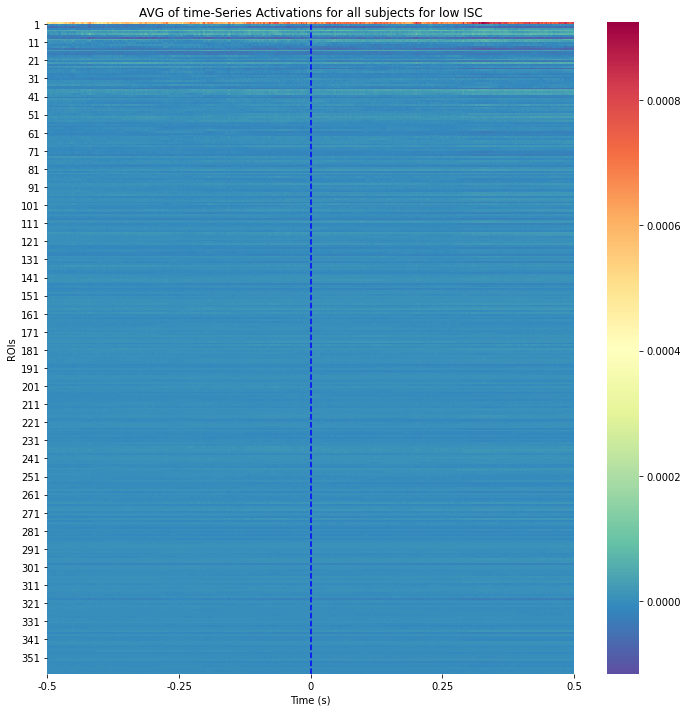

In [8]:
activation_time_series(low,'AVG of time-Series Activations for all subjects for low ISC',1,360,10,1,360,'AVG')# (differenced high with low & averaged through subjects )

In [36]:
np.where( np.max(np.average(high,axis=0)) == np.average(high,axis=0) ) # highest 

(array([35]), array([382]))

In [7]:
np.shape(high)

(10, 360, 500)

In [ ]:
numpy matplotlib sns mne pandas scipy nilearn surfplot plotly chart_studio